In [149]:
import sys, pip, numpy as np, pandas as pd, matplotlib.pyplot as plt
from streaming_func import clean_streaming_df

In [150]:
# Importing necessary libraries & modules; checking system compatibility
import sys, pip, numpy as np, pandas as pd, matplotlib.pyplot as plt

print(sys.executable)
print(sys.version)
print(pip.__version__)
print(np.__version__, pd.__version__)

/Users/jonaskorganas/coding_projects/streaming_analysis/.venv/bin/python
3.14.2 (main, Dec  5 2025, 16:49:16) [Clang 17.0.0 (clang-1700.4.4.1)]
25.3
2.3.5 2.3.3


In [151]:
# Loading Netflix dataset & info on it for understanding structure & content

netflix_ds_path = '/Users/jonaskorganas/coding_projects/streaming_analysis/netflix_titles.csv'
netflix_df = pd.read_csv(netflix_ds_path)
print(netflix_df.head(), '\n')
print(netflix_df.info())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [152]:
unique_genre_types = netflix_df.listed_in.unique()
print("Media types in netflix dataset:", unique_genre_types)

Media types in netflix dataset: ['Documentaries' 'International TV Shows, TV Dramas, TV Mysteries'
 'Crime TV Shows, International TV Shows, TV Action & Adventure'
 'Docuseries, Reality TV'
 'International TV Shows, Romantic TV Shows, TV Comedies'
 'TV Dramas, TV Horror, TV Mysteries' 'Children & Family Movies'
 'Dramas, Independent Movies, International Movies'
 'British TV Shows, Reality TV' 'Comedies, Dramas'
 'Crime TV Shows, Docuseries, International TV Shows'
 'Dramas, International Movies' 'Children & Family Movies, Comedies'
 'British TV Shows, Crime TV Shows, Docuseries' 'TV Comedies, TV Dramas'
 'Documentaries, International Movies'
 'Crime TV Shows, Spanish-Language TV Shows, TV Dramas' 'Thrillers'
 'International TV Shows, Spanish-Language TV Shows, TV Action & Adventure'
 'International TV Shows, TV Action & Adventure, TV Dramas'
 'Comedies, International Movies'
 'Comedies, International Movies, Romantic Movies'
 'Docuseries, International TV Shows, Reality TV'
 'Comedies

In [153]:
# Data cleaning function for Amazon Prime dataset for easier exploration & manipulation

test_netflix_df = clean_streaming_df(netflix_df)
print(test_netflix_df.head(), '\n')
print(test_netflix_df.info())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast          country  \
0                                                 []  [United States]   
1  [Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...   [South Africa]   
2  [Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...               []   
3                                                 []               []   
4  [Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...          [India]   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 

In [154]:
netflix_df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

In [155]:
# Movies-only DataFrame
test_movies_df = test_netflix_df[test_netflix_df["type"] == "Movie"].copy()

# TV-Shows-only DataFrame
test_tv_shows_df = test_netflix_df[test_netflix_df["type"] == "TV Show"].copy()

print("Movies:", len(test_movies_df))
print("TV Shows:", len(test_tv_shows_df))

Movies: 6131
TV Shows: 2676


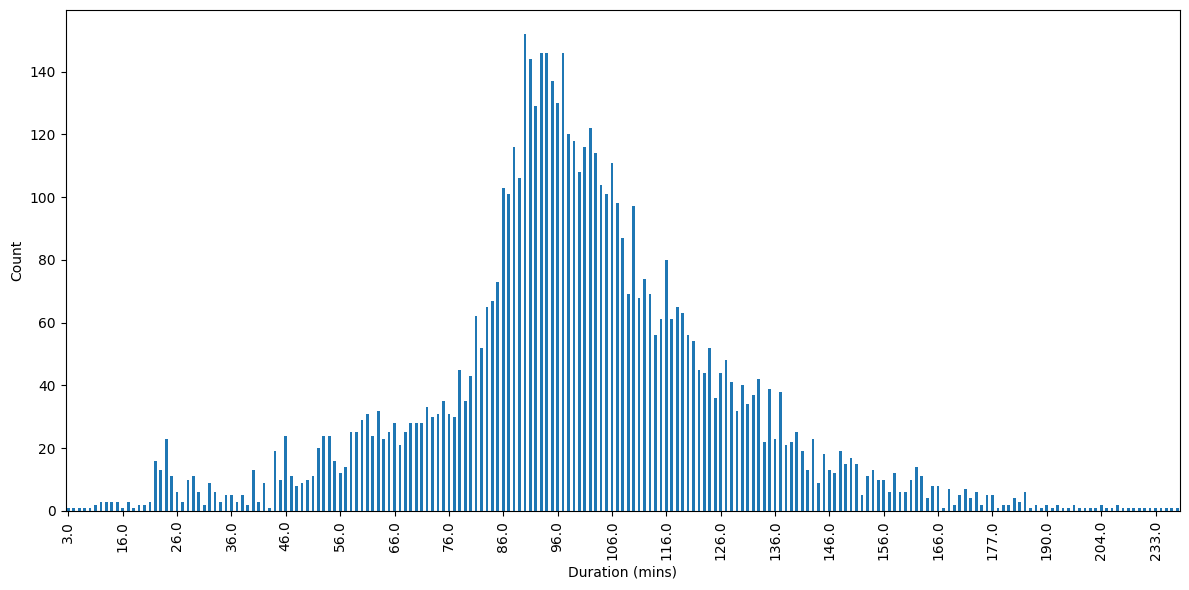

In [156]:
movies_ax = test_movies_df.groupby("duration_mins").size().plot(kind="bar", figsize=(12,6))

movies_ax.set_xticks(movies_ax.get_xticks()[::len(movies_ax.get_xticks()) // 20])
movies_ax.set_xlabel("Duration (mins)")
movies_ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

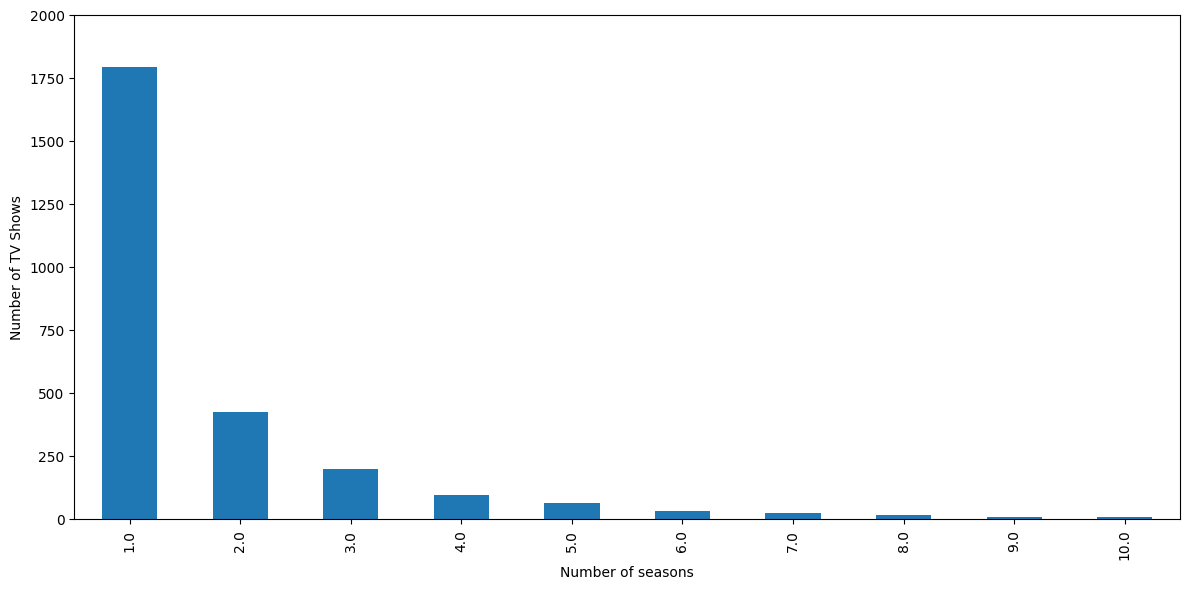

In [157]:
# Filtering for TV shows with 10 seasons or less, as few tv shows ever suceed enough tp exceed this number
filtered_tv = test_tv_shows_df[test_tv_shows_df["duration_seasons"] <= 10]

shows_ax = filtered_tv.groupby("duration_seasons").size().plot(kind="bar", figsize=(12,6))

shows_ax.set_xticks(shows_ax.get_xticks()[::len(shows_ax.get_xticks()) // 10])
shows_ax.set_yticks(shows_ax.get_yticks()[::len(shows_ax.get_yticks()) // 8])
shows_ax.set_xlabel("Number of seasons")
shows_ax.set_ylabel("Number of TV Shows")
plt.tight_layout()
plt.show()

<Axes: >

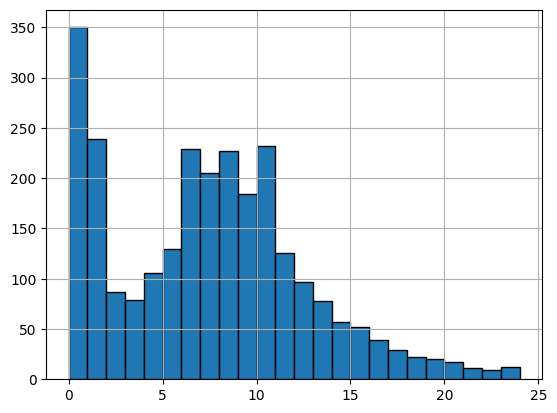

In [158]:
test_tv_shows_df["cast_count"] = test_tv_shows_df["cast"].apply(len)
test_tv_shows_df["cast_count"].hist(bins=range(0, 25), edgecolor='black')

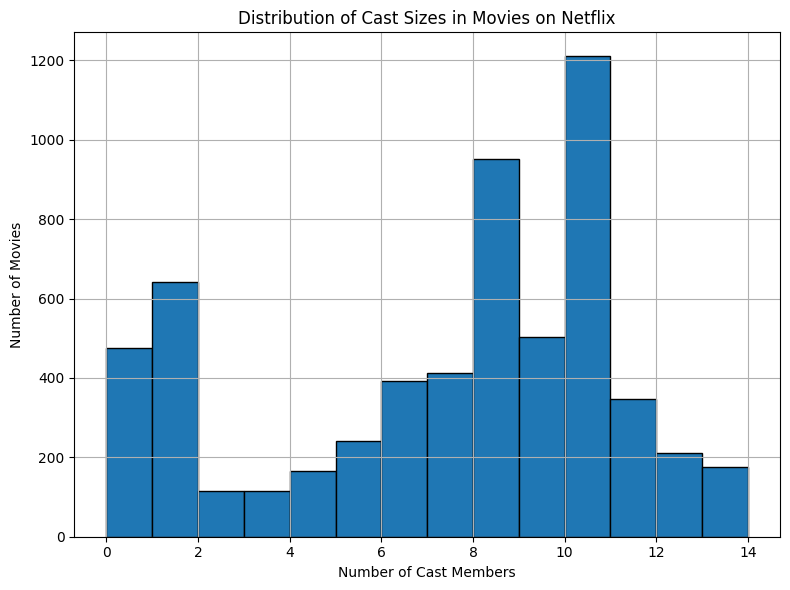

In [159]:
# # Movies cast size distribution (focused more specifically on casts with 15 or less members, due to their more recorded frequent occurrences)
test_movies_df["cast_count"] = test_movies_df["cast"].apply(len)
test_movies_df["cast_count"].hist(bins=range(0, 15), edgecolor='black', figsize=(8,6))

plt.xlabel("Number of Cast Members")
plt.ylabel("Number of Movies")
plt.title("Distribution of Cast Sizes in Movies on Netflix")

plt.tight_layout()
plt.show()

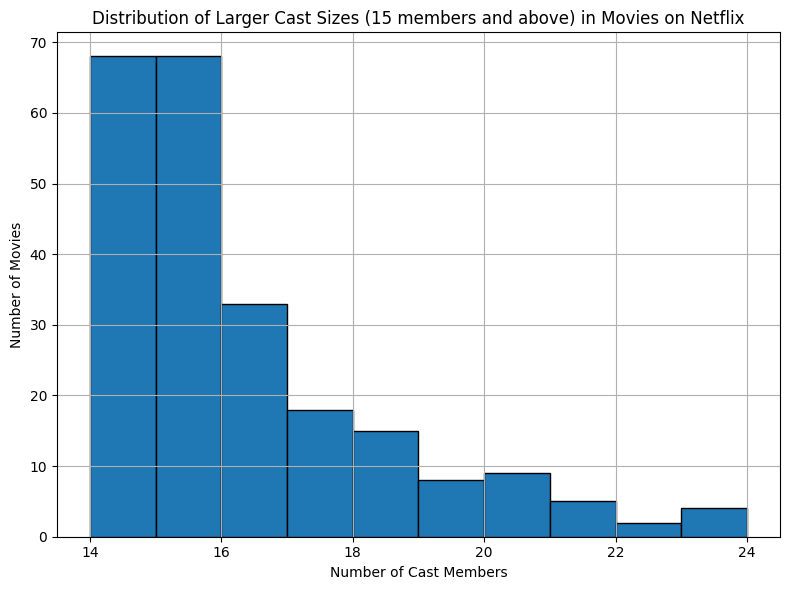

In [160]:
# Movies cast size distribution (focused more specifically on larger casts, due to their less frequent occurrence)

test_movies_df["cast_count"].hist(bins=range(14, 25), edgecolor='black', figsize=(8,6))

plt.xlabel("Number of Cast Members")
plt.ylabel("Number of Movies")
plt.title("Distribution of Larger Cast Sizes (15 members and above) in Movies on Netflix")

plt.tight_layout()
plt.show()

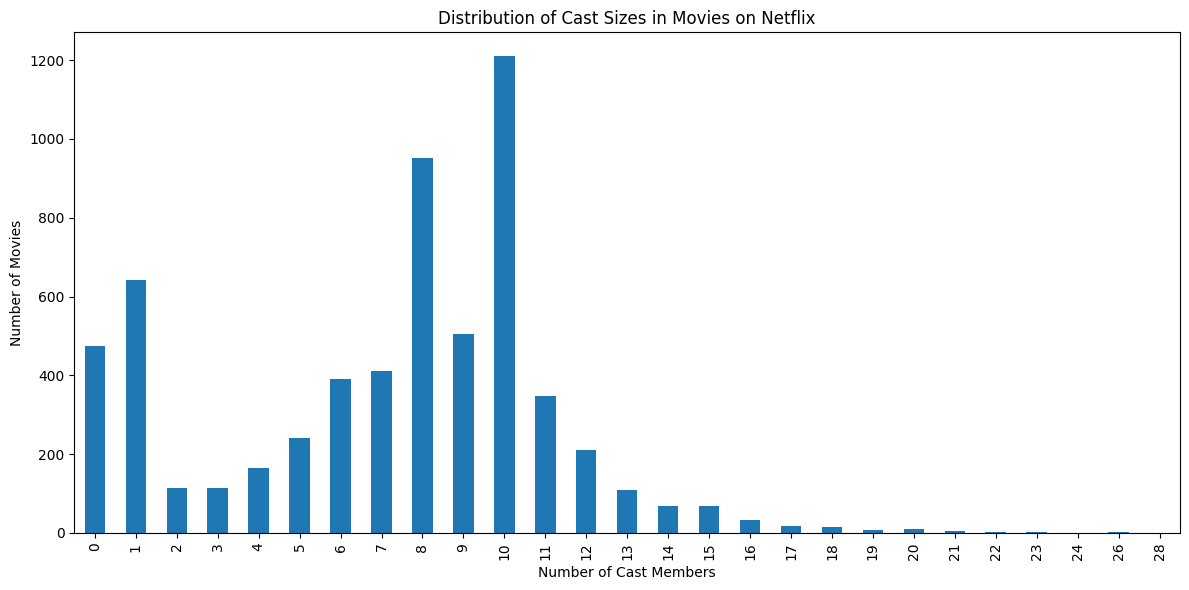

In [161]:
# Movies cast size distribution using bar plot for better visualization

test_movies_df["cast_count"] = test_movies_df["cast"].apply(len)
'''
test_movies_bar = test_movies_df.groupby("cast_count").size().plot(kind="bar", figsize=(8,4))
test_movies_bar.set_xlabel("Number of Cast Members")
test_movies_bar.set_ylabel("Number of Movies")
test_movies_bar.set_title("Distribution of Cast Sizes in Movies on Netflix")
'''

'''
several films have been recorded to have casts of 30 or more, which is most likely an error in the dataset or an inclusion of all minor roles & extras;
as a result, we'll exclude those from the visualization for better clarity & to remove potential skewing of the data & outliers
'''

test_movies_bar_sample = test_movies_df[test_movies_df["cast_count"] <= 30]
test_movies_bar_sample = test_movies_bar_sample.groupby("cast_count").size().plot(kind="bar", figsize=(12,6))
test_movies_bar_sample.set_xlabel("Number of Cast Members")
test_movies_bar_sample.set_ylabel("Number of Movies")
test_movies_bar_sample.set_title("Distribution of Cast Sizes in Movies on Netflix")
plt.tight_layout()
plt.show()

In [162]:
# Extracting unique genres from Netflix dataset
netflix_media_genres = test_netflix_df["listed_in"]
unique_netlfix_genres = []

for films in netflix_media_genres:
    for genre in films:
        
        # Check & append unique genres only
        if genre not in unique_netlfix_genres:
            unique_netlfix_genres.append(genre)

print(unique_netlfix_genres)
print(len(unique_netlfix_genres))

['Documentaries', 'International TV Shows', 'TV Dramas', 'TV Mysteries', 'Crime TV Shows', 'TV Action & Adventure', 'Docuseries', 'Reality TV', 'Romantic TV Shows', 'TV Comedies', 'TV Horror', 'Children & Family Movies', 'Dramas', 'Independent Movies', 'International Movies', 'British TV Shows', 'Comedies', 'Spanish-Language TV Shows', 'Thrillers', 'Romantic Movies', 'Music & Musicals', 'Horror Movies', 'Sci-Fi & Fantasy', 'TV Thrillers', "Kids' TV", 'Action & Adventure', 'TV Sci-Fi & Fantasy', 'Classic Movies', 'Anime Features', 'Sports Movies', 'Anime Series', 'Korean TV Shows', 'Science & Nature TV', 'Teen TV Shows', 'Cult Movies', 'TV Shows', 'Faith & Spirituality', 'LGBTQ Movies', 'Stand-Up Comedy', 'Movies', 'Stand-Up Comedy & Talk Shows', 'Classic & Cult TV']
42


In [163]:
test_netflix_casts = test_netflix_df["cast"]    # Series of lists

# Extract unique cast members from the Netflix dataset & add to a set
test_netflix_unique_cast_members = set()

# Iterate through each cast entry in the dataset
for cast_list in test_netflix_casts:

    # cast_list is already a list (or []), thanks to clean_streaming_df
    if not cast_list:          # handles empty lists
        continue

    # Split multiple cast members & add unique ones to the set
    for actor in cast_list:

        # paranoia, but good check to have
        if not isinstance(actor, str):
            continue           

        actor = actor.strip()
        
        # skip empty strings
        if actor:  
            test_netflix_unique_cast_members.add(actor)

test_netflix_unique_cast_members = list(test_netflix_unique_cast_members)

print(test_netflix_unique_cast_members[:10])
print(len(test_netflix_unique_cast_members))

['Bea Segura', 'Ryan Walter', 'Omar Epps', 'Tomasz Karolak', 'Mika Kikuchi', 'Vivian Lai', 'Albert Baró', 'Ben Freeman', 'Pavel Vorontsov', 'Michael Zegen']
36439


In [ ]:
# explode netflix movie genres into separate rows
movies_df_exploded = test_movies_df.explode("listed_in").copy()

# adding cast count column to the exploded dataframe
movies_df_exploded["cast_count"] = movies_df_exploded["cast"].str.len()

# Removing empty genres that become NaN after explode, before the groupby
movies_df_exploded = movies_df_exploded[movies_df_exploded["listed_in"].notna()]

# Total number of role appearances in each genre (counting a movie once per genre)
movie_genre_cast_counts = movies_df_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
print(movie_genre_cast_counts)

listed_in
Dramas                      20767
International Movies        20491
Comedies                    15185
Action & Adventure           8054
Independent Movies           6297
Children & Family Movies     5601
Romantic Movies              5214
Thrillers                    4821
Horror Movies                3066
Music & Musicals             2399
Sci-Fi & Fantasy             2291
Documentaries                1217
Sports Movies                1140
Classic Movies               1022
Cult Movies                   723
Anime Features                685
LGBTQ Movies                  662
Stand-Up Comedy               486
Faith & Spirituality          475
Movies                        289
Name: cast_count, dtype: int64


In [ ]:
print(test_movies_df["cast"].head(),'\n')
print(movies_df_exploded[["title", "listed_in", "cast_count"]].head(10), '\n')

# 
print(movies_df_exploded["listed_in"].value_counts().head(), '\n')

0                                                    []
6     [Vanessa Hudgens, Kimiko Glenn, James Marsden,...
7     [Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra ...
9     [Melissa McCarthy, Chris O'Dowd, Kevin Kline, ...
12    [Luna Wedler, Jannis Niewöhner, Milan Peschel,...
Name: cast, dtype: object 

                               title                 listed_in  cast_count
0               Dick Johnson Is Dead             Documentaries           0
6   My Little Pony: A New Generation  Children & Family Movies          10
7                            Sankofa                    Dramas           8
7                            Sankofa        Independent Movies           8
7                            Sankofa      International Movies           8
9                       The Starling                  Comedies          11
9                       The Starling                    Dramas          11
12                      Je Suis Karl                    Dramas          11
12               

In [ ]:
# Movies unique genres count only

def unique_actors_per_genre(df: pd.DataFrame) -> pd.Series:
    """
    The dataframe is expected to be a cleaned 'streaming dataframe' where:
      - df['cast'] is a list of actor names (or [])
      - df['listed_in'] is a list of genres (or [])
    
    Returns a Series indexed by genre, with the number of UNIQUE actors
    that have ever appeared in at least one title in that genre.
    """

    # Explode genres so each row has 1 genre
    exploded = df.explode("listed_in")

    # Explode cast so each row has 1 actor & 1 genre
    exploded = exploded.explode("cast")

    # Clean up: drop empty/NaN genres & actors
    exploded["listed_in"] = exploded["listed_in"].astype(str).str.strip()
    exploded["cast"] = exploded["cast"].astype(str).str.strip()

    mask = (
        exploded["listed_in"].notna() &
        (exploded["listed_in"] != "") &
        exploded["cast"].notna() &
        (exploded["cast"] != "")
    )
    exploded = exploded[mask]

    # Group by genre & count unique actors
    genre_actor_counts = (
        exploded
        .groupby("listed_in")["cast"]
        .nunique()          # <– unique actors per genre
        .sort_values(ascending=False)
    )

    return genre_actor_counts

movie_unique_actors_per_genre = unique_actors_per_genre(test_movies_df)

print(movie_unique_actors_per_genre.head(10)) # top 10 movie genres by unique actors
print(len(movie_unique_actors_per_genre)) # answers how many for each movie genre, how many distinct actors have appeared in at least one movie of that genre


listed_in
Dramas                      14228
International Movies        13443
Comedies                    10148
Action & Adventure           5793
Independent Movies           5368
Romantic Movies              4329
Thrillers                    4029
Children & Family Movies     3835
Horror Movies                2751
Music & Musicals             2029
Name: cast, dtype: int64
20


In [178]:
# tv-shows unique genres count only
tv_unique_actors_per_genre = unique_actors_per_genre(test_tv_shows_df)

print(tv_unique_actors_per_genre.head(10)) # top 10 tv-show genres by unique actors
print(len(tv_unique_actors_per_genre)) # answers how many for each tv-show genre, how many distinct actors have appeared in at least one tv-show of that genre

listed_in
International TV Shows       8752
TV Dramas                    6671
TV Comedies                  3904
Crime TV Shows               3596
Romantic TV Shows            2542
Kids' TV                     2400
TV Action & Adventure        1700
Spanish-Language TV Shows    1452
British TV Shows             1159
TV Mysteries                 1045
Name: cast, dtype: int64
22


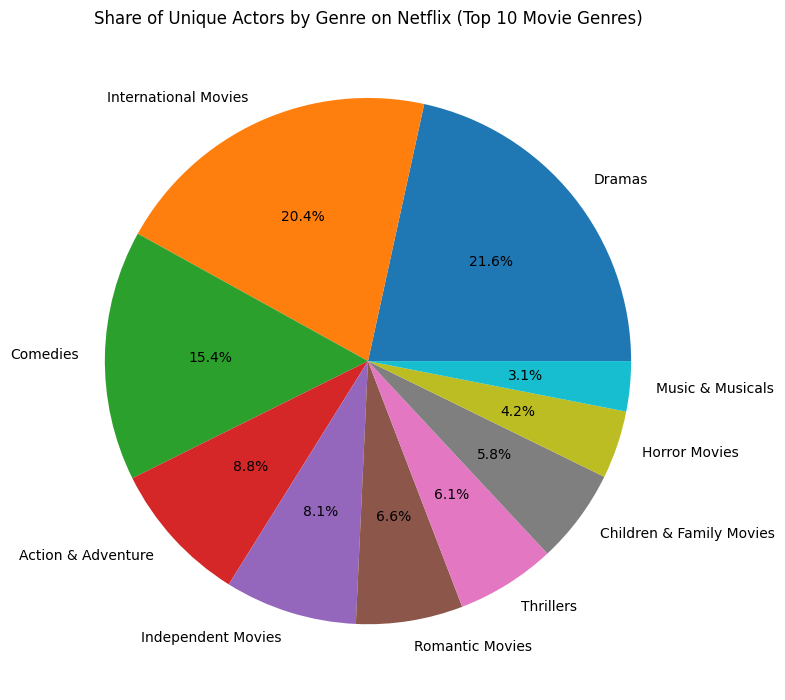

In [182]:
# Pie chart of unique actors per movie genre (top 10 genres only)

top_n = 10
top_genres = movie_unique_actors_per_genre.head(top_n)

plt.figure(figsize=(8, 8))
top_genres.plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")  # hide y-label
plt.title("Share of Unique Actors by Genre on Netflix (Top 10 Movie Genres)")
plt.tight_layout()
plt.show()

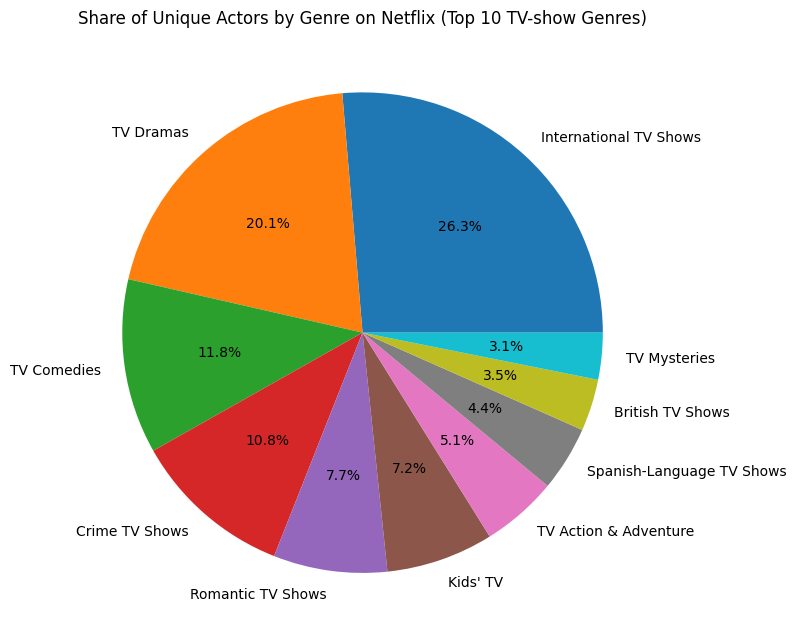

In [183]:
# Pie chart of unique actors per TV-show genre (top 10 genres only)

top_n = 10
top_genres = tv_unique_actors_per_genre.head(top_n)

plt.figure(figsize=(8, 8))
top_genres.plot(kind="pie", autopct="%1.1f%%")
plt.ylabel("")  # hide y-label
plt.title("Share of Unique Actors by Genre on Netflix (Top 10 TV-show Genres)")
plt.tight_layout()
plt.show()

In [165]:
# explode netflix tv shows genres into separate rows
shows_df_exploded = test_tv_shows_df.explode("listed_in")
shows_df_exploded["cast_count"] = shows_df_exploded["cast"].apply(len)

# sorted movie genre cast counts by ascending order to identify genres with largest casts
show_genre_cast_counts = shows_df_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
print(show_genre_cast_counts)

listed_in
International TV Shows          11210
TV Dramas                        7467
TV Comedies                      4458
Crime TV Shows                   3931
Kids' TV                         3210
Romantic TV Shows                2890
Anime Series                     2123
Spanish-Language TV Shows        1813
TV Action & Adventure            1786
British TV Shows                 1379
TV Mysteries                     1083
Korean TV Shows                  1058
TV Sci-Fi & Fantasy               864
TV Horror                         816
Teen TV Shows                     739
TV Thrillers                      599
Docuseries                        526
Reality TV                        486
Stand-Up Comedy & Talk Shows      253
Classic & Cult TV                 240
TV Shows                           97
Science & Nature TV                95
Name: cast_count, dtype: int64
